# 粒子フィルタでローレンツ63モデルの双子実験 (PF test)

Lorenz方程式とは，カオス的振る舞いをする非線形方程式の一つ．
\\[\frac{du}{dt}=-pu+pv,\ \frac{dv}{dt}=-uw+ru-v,\ \frac{dw}{dt}=uv-bw\\]
で表される．Lorenzが1963に発表したモデルであることから，Lorenz'63 modelと呼ばれる．

## オイラーの前進差分による更新関数

In [1]:
import math

import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from particle import *

In [2]:
# update
def Lorenz_update(state, param, dt) :
    u = state[0]
    v = state[1]
    w = state[2]
    p = param[0]
    r = param[1]
    b = param[2]
    new_state = np.zeros(3)
    new_state[0] = u + dt * p * (- u + v)
    new_state[1] = v + dt * (- u*w + r*u - v)
    new_state[2] = w + dt * (u*v - b*w)
    return new_state

# perfect simulation function
def Lorenz_perfect(initial, param, time, dt) :
    t = 0
    state = initial
    l = math.ceil(time / dt) + 1
    u = np.zeros(l + 1)
    v = np.zeros(l + 1)
    w = np.zeros(l + 1)
    u[0] = initial[0]
    v[0] = initial[1]
    w[0] = initial[2]
    for i in range(l) :
        state = Lorenz_update(state, param, dt)
        u[i + 1] = state[0]
        v[i + 1] = state[1]
        w[i + 1] = state[2]
    return u, v, w

def Lorenz_perfect_noise(initial, param, time, dt, sigma) :
    t = 0
    state = initial
    l = math.ceil(time / dt) + 1
    u = np.zeros(l + 1)
    v = np.zeros(l + 1)
    w = np.zeros(l + 1)
    u[0] = initial[0]
    v[0] = initial[1]
    w[0] = initial[2]
    for i in range(l) :
        noise = rd.normal(0, sigma, size = 3)
        state = Lorenz_update(state, param, dt) + noise
        u[i + 1] = state[0]
        v[i + 1] = state[1]
        w[i + 1] = state[2]
    return u, v, w

# initial particle
def Initial_particle(mu_0, initial_sd, n_particle) :
    return rd.normal(mu_0, initial_sd, size = n_particle)

## 双子実験

双子実験：決定論的シミュレーションによって得られたデータを観測値とし，<br>
どれぐらいデータ同化による予測が一致しているか確認する手法．<br>
カオス系のLorenzモデルがよく用いられる．

In [3]:
# parameter
n_dim = 3
n_particle = 10**2

# sys_sigma, obs_sigma are variance
sys_sigma = 0.027
obs_sigma = 2.615

# make sigma is standard deviation
make_sigma = 0.1
initial = np.array([5.0, 5.0, 5.0])
mu_0 = np.array([4.5, 5.5, 5.5])
initial_sd = 0.01
param = np.array([10, 28, 8 / 3])
dt = 0.01
time = 15.0

In [4]:
# perfect simulation
perf_u, perf_v, perf_w = Lorenz_perfect(initial, param, time, dt)

# perfect simulation + noise
perf_u_noise, perf_v_noise, perf_w_noise = Lorenz_perfect_noise(initial, param, time, dt, make_sigma)

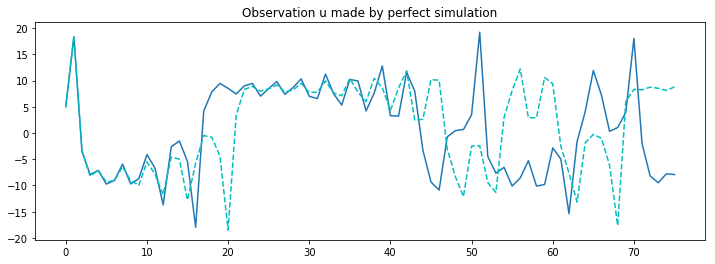

In [5]:
# plot observation from perfect simulation data
time_interval = 20
time_step = math.ceil(time / dt) + 1
time_data = np.linspace(0, time, time_step)
obs_u = np.zeros(time_step)
obs_v = np.zeros(time_step)
obs_w = np.zeros(time_step)
obs_u[:] = np.nan
obs_v[:] = np.nan
obs_w[:] = np.nan
obs_u[::time_interval] = perf_u_noise[::time_interval]
obs_v[::time_interval] = perf_v_noise[::time_interval]
obs_w[::time_interval] = perf_w_noise[::time_interval]
plt.figure(figsize = (12, 4))
plt.plot(obs_u[::time_interval], label = 'obs_u')
plt.plot(perf_u[::time_interval], linestyle = '--', color = 'c', label = 'perf_u')
plt.title("Observation u made by perfect simulation")
plt.show()

In [6]:
print(obs_u)

[ 5.               nan        nan ...        nan        nan -7.9259828]


In [7]:
y = np.c_[obs_u, obs_v, obs_w]
y.shape

(1501, 3)

In [8]:
def transition_function(state, noise):
    param = np.array([10, 28, 8 / 3])
    dt = 0.01
    
    u = state[0]
    v = state[1]
    w = state[2]
    p = param[0]
    r = param[1]
    b = param[2]
    new_state = np.zeros_like(state)
    new_state[0] = u + dt * p * (- u + v)
    new_state[1] = v + dt * (- u*w + r*u - v)
    new_state[2] = w + dt * (u*v - b*w)
    return new_state + noise

In [9]:
y = y.astype(np.float16)

In [10]:
def log_norm_likelihood(y, x, H, R, n_particle) :
    '''
    y [n_dim_obs] {numpy-array, float} 
        : observation
        観測 [観測変数軸]
    mean = H @ x [n_particle, n_dim_obs] {numpy-array, float}
        : mean of normal distribution
        各粒子に対する正規分布の平均 [粒子軸，観測変数軸]
    covariance = R [n_dim_obs, n_dim_obs] {numpy-array, float}
        : covariance of normal distribution
        正規分布の共分散 [観測変数軸]
    '''
    Y = np.zeros((len(y), n_particle), dtype = np.float16)
    Y.T[:] = y
    return (- 0.5 * (Y - H @ x).T @ linalg.pinv(R) @ (Y - H @ x)).diagonal()

In [11]:
likelihood_params = [np.eye(3), obs_sigma**2 * np.eye(3), 50]

In [12]:
pf = Particle_Filter(y, transition_functions = [transition_function],  initial_mean = initial,
                             initial_covariance = 2 * np.eye(3),
                             n_dim_sys = 3, n_dim_obs = 3, n_particle = 50,
                             transition_noise = (rd.multivariate_normal, [np.zeros(3), sys_sigma**2 * np.eye(3)]),
                             likelihood_functions = log_norm_likelihood, likelihood_function_parameters = likelihood_params,
                             likelihood_function_is_log_form = True, observation_parameters_time_invariant = True,
                            dtype = np.float16)
#pf.filter()
pf.smooth(lag = 100)

 filter and smooth calculating... t=1500

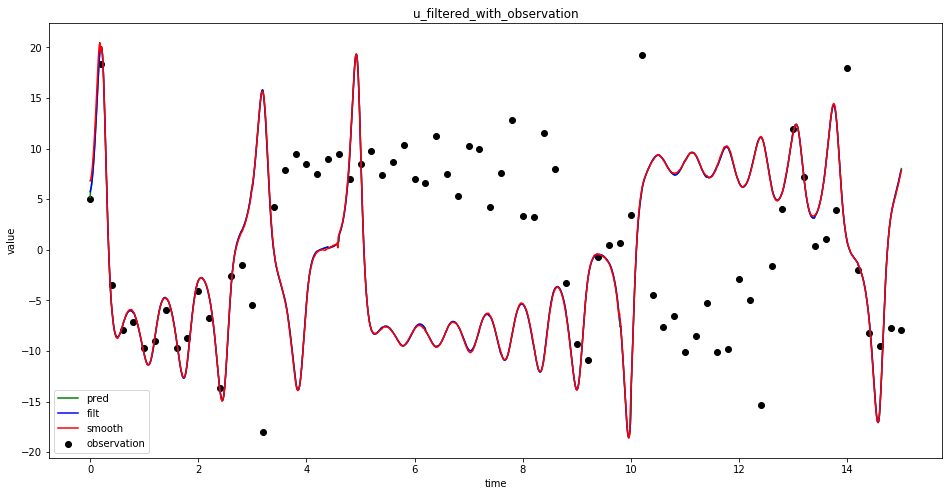

In [13]:
T = len(obs_u)
        
plt.figure(figsize=(16,8))
plt.scatter(time_data[::time_interval], obs_u[::time_interval], color = "k", marker = 'o', label = "observation")
plt.plot(time_data, pf.get_predicted_value(0), color = "g", label = "pred")
plt.plot(time_data, pf.get_filtered_value(0), color = "b", label = "filt")
plt.plot(time_data, pf.get_smoothed_value(0), color = "r", label = 'smooth')
        
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("u_filtered_with_observation")
#plt.savefig("../plot/180329_twin_experiment_PF_u.png")
plt.show()

## 時系列データ

In [12]:
ls ../../data

PF-example-data.txt                   observation.txt
annual-barley-yields-per-acre-in.csv  rhine-river-near-basle-switzerla.csv
homesurvey2015.csv


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('../../data/rhine-river-near-basle-switzerla.csv')
df.head()

,Year,Data
0,1807,864.884
1,1808,1033.141
2,1809,826.923
3,1810,1018.777
4,1811,1118.296


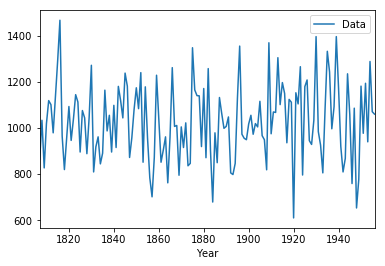

In [4]:
df.plot('Year', 'Data')

In [5]:
obs = df.Data.values / 10e1
obs[:5]

array([ 8.64884, 10.33141,  8.26923, 10.18777, 11.18296])

In [6]:
df.shape

(150, 2)

In [23]:
pf = Particle_Filter(obs, initial_mean = 8.5 * np.eye(1) , initial_covariance = np.eye(1),
                             n_dim_sys = 1, n_dim_obs = 1, n_particle = 10 ** 3,
                             transition_noise = (rd.normal, [0, 0.08]),
                            observation_covariance = 0.1 * np.eye(1), dtype = np.float16)
#pf.filter()
pf.smooth(lag = 50)

 filter and smooth calculating... t=149

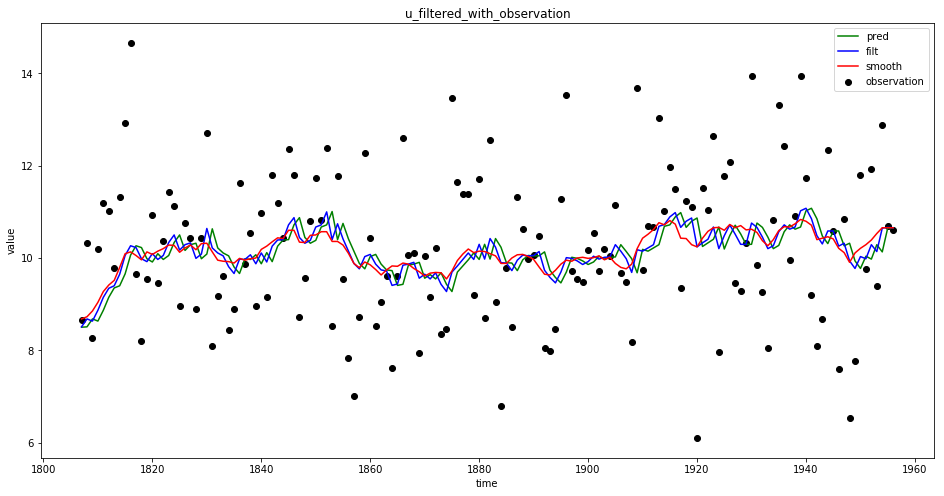

In [24]:
plt.figure(figsize=(16,8))
plt.scatter(df.Year.values, obs, color = "k", marker = 'o', label = "observation")
plt.plot(df.Year, pf.get_predicted_value(0), color = "g", label = "pred")
plt.plot(df.Year, pf.get_filtered_value(0), color = "b", label = "filt")
plt.plot(df.Year, pf.get_smoothed_value(0), color = "r", label = 'smooth')
        
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("u_filtered_with_observation")
#plt.savefig("../plot/180322_time_series_PF.png")
plt.show()

色々とテスト

In [4]:
def func(a, b):
    return a, b

a = np.arange(24).reshape(2, 3, 4)
func(*a)

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]]), array([[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]))

In [5]:
a = np.arange(4).reshape(2,2)
b = np.arange(3)
func(*[a,b])

(array([[0, 1],
        [2, 3]]), array([0, 1, 2]))

In [8]:
np.asarray([a, b])

array([array([[0, 1],
       [2, 3]]), array([0, 1, 2])], dtype=object)

In [9]:
np.asarray([a, b]).shape

(2,)

In [2]:
a = np.arange(4).reshape(2,2)
b = np.arange(4).reshape(2,2)
np.asarray([a,b]).shape

(2, 2, 2)

- 次元が一致していないとnumpyはobject型になる

In [13]:
def func(a,b,c):
    return a+b+c

a = np.arange(2)
b = np.arange(4).reshape(2,2)
func(a, *b)

array([2, 5])